# Calculating state-by-state implied infection numbers

This notebook tries to compute what the full infection numbers in the past and present likely were/are.

It does so in the past by blending variables for "median days from infection to death" and "infection fatility rate" (IFR) with smoothed death rates. In other words, days_to_death days before date D, there must have been roughly (deaths_on_date_D / IFR) infections to end up with a given number of deaths on date D.

When looking at the most recent days_to_death days, it looks up what percentage of infections were confirmed on the last day calculated in the past, and applies that percentage to the new infections found since then. It normalizes a bit by the amount of testing done on each day to try to handle significant ramping up/down of testing during that time, but the recent projections are admittedly sketchy.

The principal source of death data is files from the NY Times, supplemented by a more accurate DateOfDeath.xlsx from Massachusetts. The source of testing data is The COVID Tracking Project, maintained by The Atlantic.

NOTE: Prior to running this notebook, you should retrieve the latest DateOfDeath.xlsx file by:

1. going to https://www.mass.gov/info-details/covid-19-response-reporting,
2. downloading the raw data zip from the line saying "Raw data used to create the dashboard is available here:"
3. copying the DateofDeath.xlsx in that file to the same directory as the notebook

Yeah, that could potentially be automated, but MA made that really hard the way they implemented it.

In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib
import matplotlib.pyplot as plt

from common import load_data, smooth_series, calc_mid_weekly_average
from common import calc_state_stats, get_infections_df, find_smooth_dates

In [2]:
# Earliest date that there is sufficient data for all states, including MA
EARLIEST_DATE = pandas.Period('2020-03-10', freq='D')

# Set a latest date when the most recent days have garbage (like on or after holidays)
LATEST_DATE = pandas.Period('2020-12-24', freq='D')
LATEST_DATE = None

# Set a number of recent days to not display in the graphs for lack of future days to smooth them
NON_DISPLAY_DAYS = 2

In [3]:
latest_date, meta, nyt_stats, ct_stats = load_data(EARLIEST_DATE, LATEST_DATE)
latest_displayed = latest_date - NON_DISPLAY_DAYS
print(f"Latest date = {str(latest_date)}; latest displayed = {str(latest_displayed)}")

Latest date = 2020-12-29; latest displayed = 2020-12-27


In [4]:
# nyt_stats.tail(2)

In [5]:
# ct_stats.tail(2)

### Put the two datasets together

In [6]:
ct1 = ct_stats.set_index(['ST', 'Date']).sort_index()[['Pos', 'Neg']]
nyt1 = nyt_stats.set_index(['ST', 'Date']).sort_index()[['Deaths']]
both = ct1.join(nyt1)
meta_tmp = meta.set_index('ST')

In [7]:
states = [calc_state_stats(state, df, meta_tmp, latest_date)
          for state, df in both.reset_index().groupby('ST')]
# states[-17].tail(2)

In [8]:
stats = pandas.concat(states).reset_index()
# stats[stats.ST == 'WV'].tail(5)[['Date', 'RawDeaths', 'Deaths', 'Deaths7']]

### Calculate new stats, state by state

In [9]:
# Median number of days between being exposed and developing illness
INCUBATION = 4

# Number of days one is infectious (this isn't actually used yet)
INFECTIOUS = 10

# Median days in between exposure and death
DEATH_LAG = 19

In [10]:
# Here is where you set variables for IFR assumptions

# Note that this IFR represents a country-wide average on any given day, but the IFRs
# are actually adjusted up/down based on median age and nursing home residents per capita

# This set represents my worst case scenario (in my 95% CI interval)
# Start by setting the inital and final IFRs
IFR_S, IFR_E = 0.012, 0.005
# Then set dates in between by which it linearly scales to various targets
IFR_BREAKS = [['2020-04-30', 0.009], ['2020-07-31', 0.006], ['2020-09-15', 0.005]]

# This set is my optimistic scenario
IFR_S, IFR_E = 0.01, 0.003
IFR_BREAKS = [['2020-04-30', 0.0075], ['2020-07-31', 0.0045], ['2020-09-15', 0.003]]

# This set is a highly optimistic scenario that matches the recent CDC data
IFR_S, IFR_E = 0.009, 0.0025
IFR_BREAKS = [['2020-04-30', 0.007], ['2020-07-31', 0.003], ['2020-09-15', 0.002]]

# This is my expected scenario
IFR_S, IFR_E = 0.01, 0.004
IFR_BREAKS = [['2020-04-30', 0.0085], ['2020-07-31', 0.005], ['2020-09-15', 0.004]]

In [11]:
IFR_S_S, IFR_E_S = f'{100*IFR_S:.1f}%', f'{100*IFR_E:.2f}%'
infected_states = get_infections_df(states, meta, DEATH_LAG, IFR_S, IFR_E, IFR_BREAKS, INCUBATION, INFECTIOUS)
EST_LINE = str(latest_date - (DEATH_LAG - 1))
print(f"Total infected by {latest_date}: {int(infected_states.NewInf.sum()):,}")
print(f"Vertical line marking recent estimations set at {EST_LINE}")
# infected_states.tail(3)

Total infected by None: 72458200.61091734
Vertical line marking recent estimations set at 2020-12-11


In [19]:
# Checking infection totals by an arbitrary date
INF_DATE = '2020-12-01'
fizz = infected_states.reset_index()
fizz = fizz[fizz.Date <= '2020-12-01']
print(f"Total infected by {INF_DATE}: {int(fizz.NewInf.sum()):,}")

Total infected by 2020-12-01: 56,812,687


## Now for the charts

In [20]:
# Just nicking off the values we don't want to display here
fazzy = infected_states.reset_index()
fazzy = fazzy[fazzy.Date <= latest_displayed]
fazzy = fazzy.set_index(['ST', 'Date'])
infected_states = fazzy

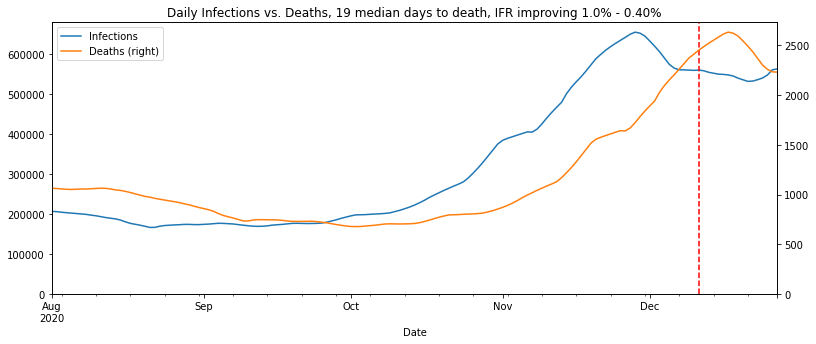

In [23]:
foozle = infected_states.reset_index()[['Date', 'NewInf', 'Deaths7']].groupby('Date').sum()
foozle.columns = ['Infections', 'Deaths']
foozle = foozle.loc['2020-08-01':, :]
fam = foozle.plot(
    title=f"Daily Infections vs. Deaths, 19 median days to death, "
          f"IFR improving {IFR_S_S} - {IFR_E_S}",
    secondary_y='Deaths', figsize=(13,5), ylim=0)
__ = fam.axvline(EST_LINE, color="red", linestyle="--")
__ = fam.get_figure().get_axes()[1].set_ylim(0)

In [24]:
foo = infected_states.reset_index()[['Date', 'Region', 'NewInf', 'Deaths7', 'Pop']]
foo = foo.groupby(['Region', 'Date']).sum()
foo['NIPerM'] = foo.NewInf / foo.Pop
foo['DPerM'] = foo.Deaths7 / foo.Pop

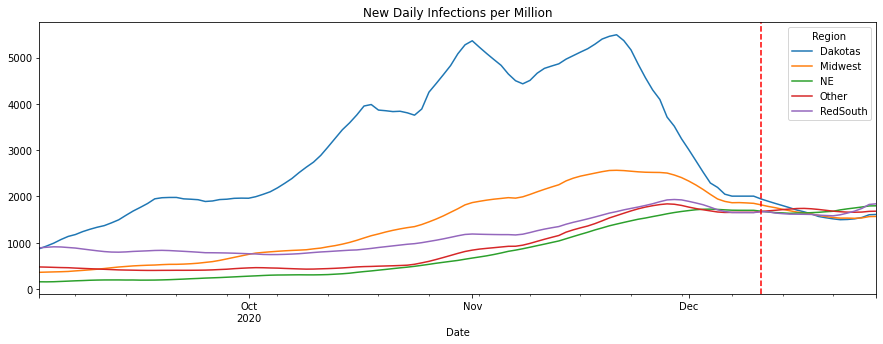

In [25]:
zzz = foo.reset_index()
zzz = zzz[zzz.Date > '2020-09-01']
fam = pandas.pivot_table(zzz, values = 'NIPerM', index=['Date'],
                         columns = 'Region').plot(title="New Daily Infections per Million", figsize=(15,5))
__ = fam.axvline(EST_LINE, color="red", linestyle="--")

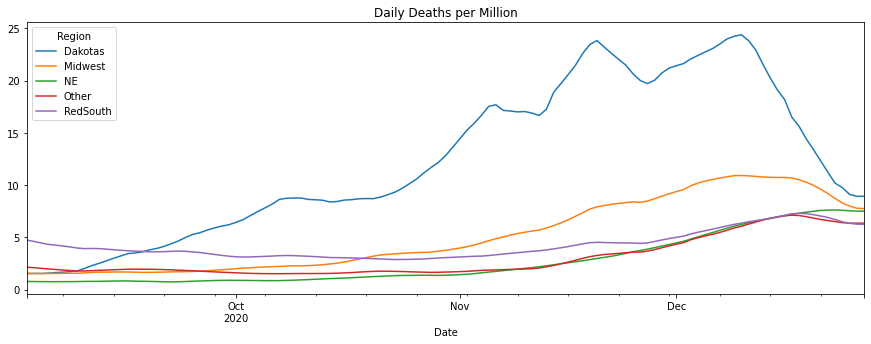

In [26]:
# was foo.reset_index()
fam = pandas.pivot_table(zzz, values = 'DPerM', index=['Date'],
                         columns = 'Region').plot(title="Daily Deaths per Million", figsize=(15,5))

In [27]:
foo = infected_states.reset_index().set_index(['Date', 'ST']).sort_index()
foo = foo[['Pop', 'Confirms7', 'Deaths7', 'NewInf', 'AIPer1000', 'AUPer1000', 'PctFound']]
faz = foo.loc[latest_displayed, :].sort_values('AUPer1000', ascending=False).copy()
faz = faz.reset_index()[['ST', 'Pop', 'Confirms7', 'Deaths7', 'AIPer1000', 'AUPer1000', 'PctFound']]
faz.columns = ['ST', 'Pop', 'Cases', 'Deaths', 'AIPer1000', 'ActUnk1000', 'PctFound']
faz.sort_values('Deaths', ascending=False).head(25)

,ST,Pop,Cases,Deaths,AIPer1000,ActUnk1000,PctFound
28,CA,39.500,37658.477928,238.006432,20.074142,10.029410,0.504594
38,TX,29.000,13959.237890,161.875006,11.952395,6.903669,0.458592
3,PA,12.800,7342.585452,159.795096,27.072327,20.684692,0.209205
21,NY,19.450,10869.311916,137.258453,17.373957,11.862455,0.292950
9,IL,12.670,5284.895696,131.339663,20.353769,15.563494,0.216665
39,FL,21.480,9640.240802,93.780038,10.950358,6.220878,0.371308
15,MI,9.987,2775.075387,88.872555,16.982088,13.848360,0.172745
2,AZ,7.279,5828.214741,71.672729,30.442280,22.031164,0.246667
7,IN,6.732,4114.177369,68.644117,22.906504,15.882714,0.254621
43,OH,11.690,6610.326986,67.908596,11.525390,5.189157,0.494742


In [29]:
fam = infected_states[['Pop', 'Confirms7', 'Deaths7', 'NewInf']].copy()
fam['C7Per'] = fam.Confirms7 / fam.Pop
fam['D7Per'] = fam.Deaths7 / fam.Pop
fam['NIPer'] = fam.NewInf / fam.Pop
fam = fam.reset_index()[['ST', 'NIPer', 'C7Per', 'D7Per']]
fam.columns = ['ST', 'Infections', 'Confirms', 'Deaths']
fam = fam.groupby('ST').max().copy()
print("Maximum deaths/M/day states ever had")
fam.sort_values('Deaths', ascending=False).head(15)

Maximum deaths/M/day states ever had


,Infections,Confirms,Deaths
ST,,,
NY,4820.194567,558.833518,49.863929
NJ,3356.888407,556.887755,34.804469
CT,2660.910987,749.528383,29.308866
SD,6092.997368,1600.517130,27.215282
MA,2458.176439,712.692853,25.396957
ND,5589.299167,1851.170389,24.653168
IA,3812.934880,1148.088349,18.034856
DC,2371.994561,375.874429,16.072151
NM,4302.569026,1163.935860,15.714286


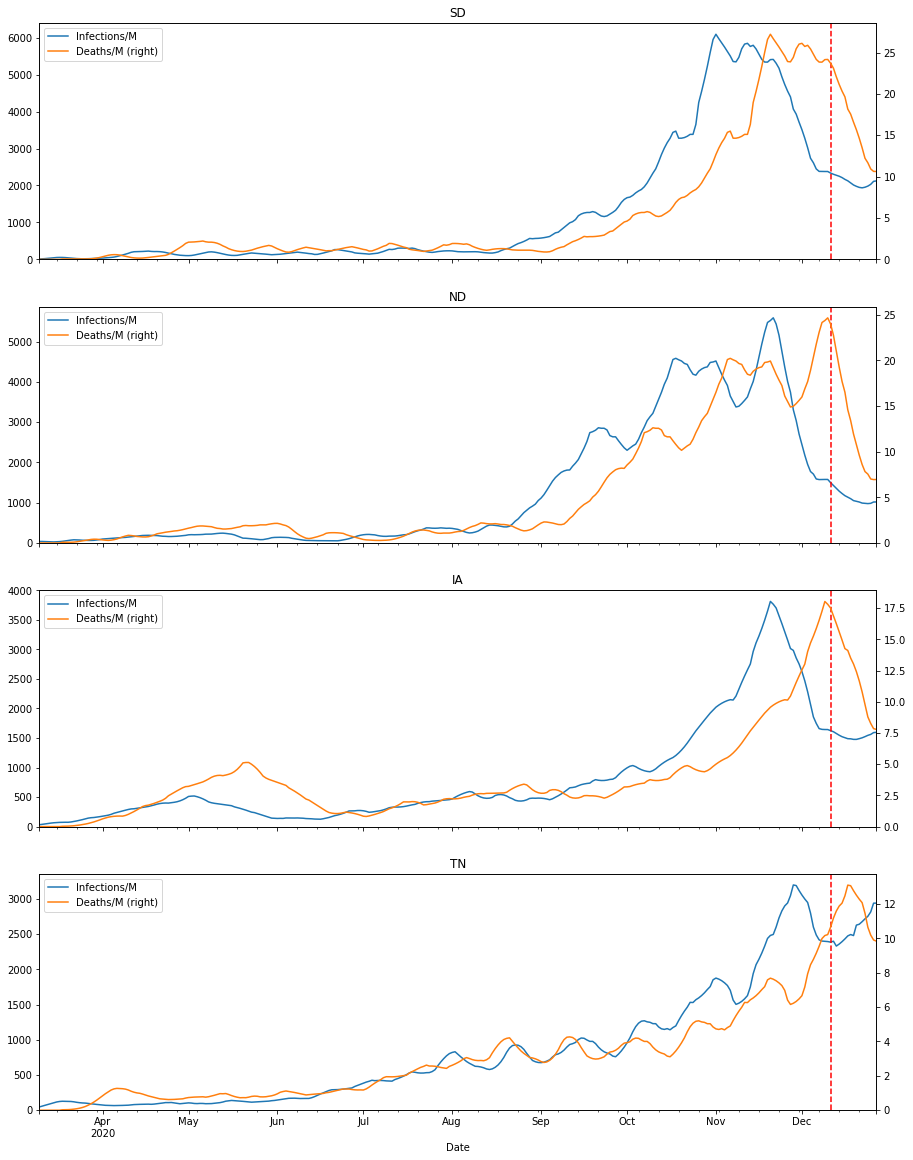

In [30]:
# This is where I noodle around to investigate particular states of interest

# This next line lists all 51 (DC included)
st_names = list(infected_states.index.get_level_values(0).unique())

st_names = ['DC', 'NM', 'MA', 'VA']
st_names = ['SD', 'ND', 'IA', 'TN']
st_names = ['NM', 'WY']
st_names = ['CA', 'TX', 'PA', 'IL', 'NY', 'MI', 'FL', 'TN', 'AZ', 'OH', 'GA', 'NC', ]
st_names = ['SD', 'ND', 'IA', 'TN']
num_plots = max(len(st_names), 2)
fig, axes = plt.subplots(num_plots, figsize=(15, 5*num_plots))
for i, st in enumerate(st_names):
    data = infected_states.loc[st, :].reset_index()[['Date', 'NIPerM', 'DPerM']].copy()
    # data = data[data.Date >= '2020-09-01']
    data.columns = ['Date', 'Infections/M', 'Deaths/M']
    fam = data.groupby('Date').sum().plot(
        ax=axes[i], title=st, ylim=0, secondary_y='Deaths/M',
    )
    fam.axvline(EST_LINE, color="red", linestyle="--")

axes = fam.get_figure().get_axes()
for i in range(len(axes)):
    axes[i].set_ylim(0)

In [32]:
# This lists the states with the highest percentage ever infected by a given date
# I usually will set this back about 10 days because I don't trust the estimated infections too much
DT = '2020-12-18'
ni = infected_states.reset_index()[['ST', 'Date', 'NIPerM']].copy()
ni = ni[ni.Date < DT].copy()
ni = (ni.groupby('ST').sum().NIPerM.sort_values(ascending=False) / 10000)
ni.head(20)

ST
ND    37.112186
SD    36.281532
AZ    30.964083
MS    30.761994
NM    28.952443
NJ    26.664317
AR    26.303935
LA    26.276603
NV    26.013397
MA    25.974342
IL    25.862535
RI    24.811587
MI    23.515853
NY    23.396186
DC    23.246867
IN    23.215143
TX    23.189902
TN    23.119933
GA    23.077845
IA    23.044423
Name: NIPerM, dtype: float64

In [ ]:
# Stopping the processing of this notebook
raise ValueError()

## Detritus

In [ ]:
infected_states.reset_index().columns

In [ ]:
df = infected_states.loc['WY', :][['RawInc', 'Daily', 'Deaths7', 'DPerM']]
df = df.loc['2020-11-10':, :].copy()
df

In [ ]:
df = pandas.concat(states)[['DTests7']].reset_index()
st_names = list(df.ST.unique())
fig, axes = plt.subplots(len(st_names), figsize=(10, 4*len(st_names)))
for i, state in enumerate(st_names):
    try:
        df[df.ST == state].set_index('Date').DTests7.plot(ax=axes[i], title=state)
    except:
        pass


In [ ]:
foo = {}
for st in ['FL', 'MA']:
    data = infected_states.loc[st, :].loc['2020-07-01':, :]
    data = infected_states.loc[st, :]
    # foo[st] = data.NIPerM
    foo[st] = data.DPerM
foo = pandas.DataFrame(foo)
fam = foo.plot(figsize=(15,5), legend=True, ylim=0)

In [ ]:
spaz = nyt_stats[['ST', 'Nursing', 'Pop', 'Median']].drop_duplicates().copy()
spaz['NPerM'] = spaz.Nursing / spaz.Pop
spaz.sort_values('Median', ascending=False)

In [ ]:
fizz = infected_states.reset_index()
fizz = fizz[fizz.Date <= '2020-12-01']
fizz.NewInf.sum()

In [21]:
# state = states[34]
# st, start = state.index[0]
# spans = []
# start_amt = IFR_S
# for end, end_amt in IFR_BREAKS:
#     end = pandas.Period(end, 'D')
#     idx = pandas.period_range(start=start, end=end, freq='D')
#     spans.append(pandas.Series(numpy.linspace(start_amt, end_amt, len(idx)), index=idx).iloc[0:-1])
#     start, start_amt = end, end_amt

# st, end = state.index[-1]
# idx = pandas.period_range(start=start, end=end, freq='D')
# spans.append(pandas.Series(numpy.linspace(start_amt, IFR_E, len(idx)), index=idx))
# span = pandas.concat(spans)
# span = pandas.Series(span.values, index=state.index)
# span
# # ifr = pandas.Series(numpy.linspace(IFR_S, IFR_E, len(state)), index=state.index)
# # ifr[0], ifr[-1]

In [22]:
# fam = infected_states.reset_index()[['Date', 'NewInf']].groupby('Date').sum().plot(
#     title=f"Infection Estimations, 19 median days to death, "
#           f"IFR improving {IFR_S_S} - {IFR_E_S}",
#     figsize=(13,5), legend=None, ylim=0
# )
# __ = fam.axvline(EST_LINE, color="red", linestyle="--")

In [ ]:
# fam = infected_states.reset_index()[['Date', 'Deaths7']].groupby('Date').sum().plot(
#     title="Deaths", figsize=(13,5),
#     legend=None, ylim=0, secondary_y='Deaths7'
# )